In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as plt
import metpy.calc as mpcalc
import numpy as np
import xarray as xr
import cartopy.mpl.ticker as cticker
import metpy.constants as constants
import cmaps
import matplotlib.patches as patches
from  scipy  import stats
import warnings
warnings.filterwarnings("ignore") 
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.weight"] = "bold"

In [3]:
file_temp = xr.open_dataset("/public/home/songqh/my_data/ERA5/monthly/TEMPERATURE/ERA5-temp.nc")
file_humi = xr.open_dataset("/public/home/songqh/my_data/ERA5/monthly/SPECIFIC_HUMIDITY/ERA5_spec_humid.nc")
file_hgt = xr.open_dataset("/public/home/songqh/my_data/ERA5/monthly/HGT/ERA5-hgt.nc")
file_uwnd = xr.open_dataset("/public/home/songqh/my_data/ERA5/monthly/UWND/ERA5-uwnd.nc")
file_vwnd = xr.open_dataset("/public/home/songqh/my_data/ERA5/monthly/VWND/ERA5-vwnd.nc")
temp_data = file_temp['t'].loc[file_temp.time.dt.month.isin(7),1,100:1000,:,:]
humi_data = file_humi['q'].loc[file_humi.time.dt.month.isin(7),1,100:1000,:,:]
uwnd_data = file_uwnd['u'].loc[file_uwnd.time.dt.month.isin(7),1,100:1000,:,:]
vwnd_data = file_vwnd['v'].loc[file_vwnd.time.dt.month.isin(7),1,100:1000,:,:]
hgt_data = file_hgt['z'].loc[file_vwnd.time.dt.month.isin(7),1,100:1000,:,:]
temp = np.array(temp_data)
humi = np.array(humi_data)
uwnd = np.array(uwnd_data)
vwnd = np.array(vwnd_data)
hgt = np.array(hgt_data)
lat = file_temp.latitude.loc[:]
lon = file_temp.longitude.loc[:]
lev = file_temp.level.loc[100:1000]
lev

<xarray.DataArray 'level' (level: 11)>
array([ 100,  150,  200,  250,  300,  400,  500,  700,  850,  925, 1000],
      dtype=int32)
Coordinates:
  * level    (level) int32 100 150 200 250 300 400 500 700 850 925 1000
Attributes:
    units:      millibars
    long_name:  pressure_level

In [5]:
lv = 2.5008e6
cpv = 1846.1
cw = 4218.0
q_u = uwnd*humi/constants.g * (lv+(cpv-cw)*temp)
q_v = vwnd*humi/constants.g * (lv+(cpv-cw)*temp)
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)
div_q = np.zeros((44,lev.shape[0],lat.shape[0],lon.shape[0]))
for t in range(44):
    for i in range(lev.shape[0]):
        div_q[t,i] = mpcalc.divergence(u = q_u[t,i],v = q_v[t,i],dx = dx ,dy = dy)
elate = div_q 
elate_index = np.trapz(elate[:,::-1,55:76,60:80],lev[::-1],axis=1).mean((1,2)) #ism:55-76,60-80 #pks:60-73,60-73


In [6]:
slope1,r_value1,p_value1 = np.zeros((11,181,360)), np.zeros((11,181,360)), np.zeros((11,181,360))
slope2,r_value2,p_value2 = np.zeros((11,181,360)), np.zeros((11,181,360)), np.zeros((11,181,360))
slope3,r_value3,p_value3 = np.zeros((11,181,360)), np.zeros((11,181,360)), np.zeros((11,181,360))

omega=7.292e-5 
for t in range(11):
    print(t)
    for i in range(181):
        for j in range(360):
            slope1[t,i,j], _, r_value1[t,i,j], p_value1[t,i,j], _ = stats.linregress(elate_index,hgt[:,t,i,j])
            slope2[t,i,j], _, r_value2[t,i,j], p_value2[t,i,j], _ = stats.linregress(elate_index,uwnd[:,t,i,j])
            slope3[t,i,j], _, r_value3[t,i,j], p_value3[t,i,j], _ = stats.linregress(elate_index,vwnd[:,t,i,j])

0
1
2
3
4
5
6
7
8
9
10


In [7]:
## 90% confidence level test
slope1_copy = np.where(p_value1 > 0.1, np.nan, slope1)
slope2_copy = np.where((p_value2 > 0.1) & (p_value3 > 0.1) , np.nan, slope2)
slope3_copy = np.where((p_value2 > 0.1) & (p_value3 > 0.1) , np.nan, slope3)


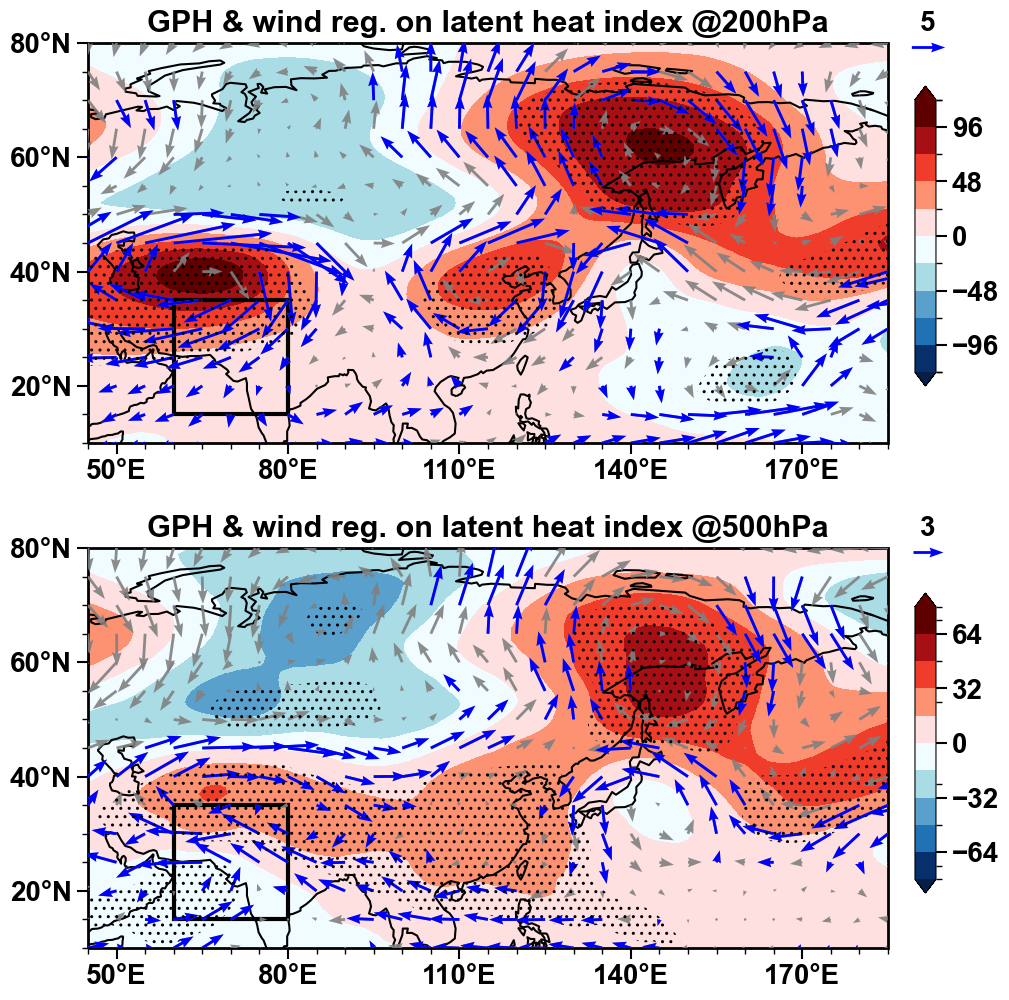

In [20]:
fig = plt.figure(figsize=(14,10))
proj = ccrs.PlateCarree(central_longitude=120)
ax1 = fig.add_axes([0.05,0.55,0.8,0.4],projection = proj)
leftlon, rightlon, lowerlat, upperlat = (45,185,10,80)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
ax1.set_extent(img_extent, crs=ccrs.PlateCarree())
ax = plt.gca()
ax.spines['geo'].set_linewidth(2)
ax1.tick_params(direction='out', length=8, width=1.5, labelsize=20,axis='both', which='major')
ax1.add_feature(cfeature.COASTLINE.with_scale('110m'),lw=1.5) 
ax1.set_xticks(np.arange(50,200,30), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(20,upperlat+20,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.minorticks_on()
ax1.tick_params(which='minor', direction='out', bottom=True, length=4, width=1)
ax1.xaxis.set_minor_locator(plt.MultipleLocator(5))
ax1.yaxis.set_minor_locator(plt.MultipleLocator(5))
ax1.set_title("GPH & wind reg. on latent heat index @200hPa",fontsize=22,weight='bold',loc='center',pad=8)
cf1 = ax1.contourf(lon,lat,slope1[2]/9.8,levels=np.linspace(-120,120,11),
                   extend = 'both',transform=ccrs.PlateCarree(), cmap=cmaps.temp_19lev)
q = ax1.quiver(lon[::5],lat[::5],slope2[2,::5,::5],slope3[2,::5,::5],scale=120,width=0.0035,alpha=0.9,headwidth=3.5,color='gray',zorder=10,
           transform=ccrs.PlateCarree())    
q = ax1.quiver(lon[::5],lat[::5],slope2_copy[2,::5,::5],slope3_copy[2,::5,::5],scale=120,width=0.0035,headwidth=3.5,color='b',zorder=10,
           transform=ccrs.PlateCarree())
qk = ax1.quiverkey(q,  1.05, 0.99, U=5, label='5',labelpos='N',zorder=30000, coordinates='axes',color='b',fontproperties={'size': 20},labelcolor='k')
ax1.add_patch(patches.Rectangle([-60,15],20,20,linewidth=3,edgecolor='k',facecolor='none',zorder=1))

cf2 = ax1.contourf(lon,lat, p_value1[2], [0,0.1,1] , zorder=100,
                     hatches=['..', None],colors="none", transform=ccrs.PlateCarree())
for collection in cf2.collections:
        collection.set_edgecolor('None')
# for collection in cf2.collections:
#         collection.set_linewidth(0)
pos = fig.add_axes([0.755,0.607,0.015,0.3])
cb = fig.colorbar(cf1,orientation='vertical',cax=pos)

cb.ax.minorticks_on()
cb.ax.tick_params(which='minor', direction='out', bottom=True, length=4, width=1,labelsize=20)
cb.ax.tick_params(which='major', direction='out', bottom=True, length=8, width=1.5,labelsize=20)
cb.ax.yaxis.set_minor_locator(plt.MultipleLocator(24))


ax2 = fig.add_axes([0.05,0.045,0.8,0.4],projection = proj)
leftlon, rightlon, lowerlat, upperlat = (45,185,10,80)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
ax2.set_extent(img_extent, crs=ccrs.PlateCarree())
ax = plt.gca()
ax.spines['geo'].set_linewidth(2)
ax2.tick_params(direction='out', length=8, width=1.5, labelsize=20,axis='both', which='major')
ax2.add_feature(cfeature.COASTLINE.with_scale('110m'),lw=1.5) 
ax2.set_xticks(np.arange(50,200,30), crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(20,upperlat+20,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.minorticks_on()
ax2.tick_params(which='minor', direction='out', bottom=True, length=4, width=1)
ax2.xaxis.set_minor_locator(plt.MultipleLocator(5))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(5))
ax2.set_title("GPH & wind reg. on latent heat index @500hPa",fontsize=22,weight='bold',loc='center',pad=8)
cf1 = ax2.contourf(lon,lat,slope1[6]/9.8,levels=np.linspace(-80,80,11),
                   extend = 'both',transform=ccrs.PlateCarree(), cmap=cmaps.temp_19lev)
q = ax2.quiver(lon[::5],lat[::5],slope2[6,::5,::5],slope3[6,::5,::5],scale=80,width=0.0035,alpha=0.9,headwidth=3.5,color='gray',zorder=10,
           transform=ccrs.PlateCarree())                   
q = ax2.quiver(lon[::5],lat[::5],slope2_copy[6,::5,::5],slope3_copy[6,::5,::5],scale=80,width=0.0035,headwidth=3.5,color='b',zorder=10,
           transform=ccrs.PlateCarree())
ax2.add_patch(patches.Rectangle([-60,15],20,20,linewidth=3,edgecolor='k',facecolor='none',zorder=1))
qk = ax2.quiverkey(q,  1.05, 0.99, U=3, label='3',labelpos='N',zorder=30000, coordinates='axes',color='b',fontproperties={'size': 20},labelcolor='k')
cf2 = ax2.contourf(lon,lat, p_value1[6], [0,0.1,1] , zorder=100,
                     hatches=['..', None],colors="none", transform=ccrs.PlateCarree())
for collection in cf2.collections:
        collection.set_edgecolor('None')
# for collection in cf2.collections:
#         collection.set_linewidth(0)
pos = fig.add_axes([0.755,0.1,0.015,0.3])
cb = fig.colorbar(cf1,orientation='vertical',cax=pos)
cb.ax.minorticks_on()
cb.ax.tick_params(which='minor', direction='out', bottom=True, length=4, width=1,labelsize=20)
cb.ax.tick_params(which='major', direction='out', bottom=True, length=8, width=1.5,labelsize=20)
cb.ax.yaxis.set_minor_locator(plt.MultipleLocator(24))
# fig.savefig("//public/home/songqh/project/figures/figure-5.jpg",dpi=600)
# fig.savefig("//public/home/songqh/project/figures/figure-5.tiff",dpi=600)